# Final project 2023 by Tatiana Soboleva

# Идея проекта
В данном проекте хочу исследовать данные о Московском метрополитене, посмотреть статистику по пассажиропотоку и определить, какие факторы на него влияют.
Цель проекта - сделать удобную визуализацию, где можно отслеживать пассажиропоток на любой станции, а также связать это с плотностью населения в районе, где расположена станция. Подробнее описано в readme.md в гитхаб.

### Шаг 1: импорт используемых библиотек

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import ipywidgets 
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from shapely.geometry import Point, LineString, Polygon
import networkx as nx
import re
import json
import requests
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import streamlit as st
import seaborn as sns
from shapely.wkt import loads

## Шаг 2: импорт данных с портала

Для начала скачаем данные с сайта mos.ru о пассажиропотоке на каждой станции московского метрополитена, а также перекодируем файл на UTF - 8, так как в изначальном источнике кодировка другая.

Данные хранятся здесь - https://data.mos.ru/opendata?categoryId=13

Данные содержат информацию о пассажиропотоке с 2021 года поквартально

In [2]:
path = "data_metro_2.csv"
metro_pas = pd.read_csv(path, sep = ";")
metro_pas.head()

,NameOfStation,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers,global_id
0,Митино,Арбатско-Покровская линия,2021,I квартал,1913498,1829031,1138975996
1,Волоколамская,Арбатско-Покровская линия,2021,I квартал,1236714,1222309,1138975997
2,Строгино,Арбатско-Покровская линия,2021,I квартал,1938816,1903731,1138975999
3,Крылатское,Арбатско-Покровская линия,2021,I квартал,1849616,1818208,1138976000
4,Площадь Революции,Арбатско-Покровская линия,2021,I квартал,2324687,2319343,1138976008


Посчитаем сколько станций сейчас открыто (включая монорельс и МЦК), причем учтем, что станции могут иметь одинаковое название, находясь на разных ветках метро.

In [3]:
stations = metro_pas[['NameOfStation','Line']].drop_duplicates()
len(stations)

298

Получается, всего **298** станций (МЦД не учтено)

К сожалению, не по всем станциям во всех кварталах имеются данные, поэтому будем учитывать это факт.
Посмотрим, на каких станциях не учитывается пассажиропоток в какой-то период времени и выясним причины, по которым пассажиропоток учитывается не везде:

In [4]:
no_pas = metro_pas[metro_pas['IncomingPassengers'] == 0]
stations_zero = no_pas['NameOfStation'].unique()
stations_zero

array(['Новослободская', 'Рижская', 'Мнёвники', 'Народное Ополчение',
       'Смоленская', 'Петровско-Разумовская', 'Третьяковская',
       'Китай-город', 'Киевская', 'Каширская', 'Тверская', 'Театральная',
       'Библиотека имени Ленина', 'Улица Старокачаловская', 'Технопарк',
       'Коломенская', 'Кантемировская', 'Царицыно'], dtype=object)

Посчитаем количество пропусков данных по этим станциям (данные с начала 2021 года, поквартально):


In [5]:
df_zero = pd.DataFrame(columns=['NameOfStation','Count_zero'])
for i in stations_zero:
    count_zero = len(no_pas[no_pas['NameOfStation'] == i])
    df_row = pd.Series([i, count_zero], index=df_zero.columns)
    df_zero = pd.concat([df_zero, df_row.to_frame().T], ignore_index=True)
df_zero.sort_values(by=['Count_zero'],ascending = False, inplace=True)
df_zero.set_index('NameOfStation')

,Count_zero
NameOfStation,
Петровско-Разумовская,7
Третьяковская,7
Китай-город,7
Киевская,7
Тверская,6
Библиотека имени Ленина,6
Театральная,6
Улица Старокачаловская,5
Рижская,5


Получаем, что больше всего непромеченных данных на таких станциях, как Петровско-разумовская, Третьяковская и Китай-город, будем учитывать этот факт в дальнейшем. 
Причины таких наблюдений:
* вестибюли этих станций соединены с другими станциями и отдельно посчитать пассажиропоток не получается (для Китай-города, Третьяковской, Петровско-Разумовской, Киевской, Тверской, Библиотеки имени Ленина, Театральной.
* на некоторых станциях, таких как Технопарк, Коломенская, Кантемировская и т.д это связано с закрытием станций зеленой ветки в конце 2022 и начале 2023 года. Также это связано с ремонтом на Рижской, Смоленской и Новослободской в течение этого срока


## Шаг 3: создаем интерактивный график с пассажиропотоком для каждой станции

Теперь сделаем интерактивные графики, которые позволяют отслеживать изменение пассажиропотока на любой станции с начала 2021 года.

In [6]:
metro_pas = metro_pas.astype({'Year': str})
#добавим колонку, объединяющую квартал и год для удобства отображения
metro_pas['Year and quarter'] = metro_pas['Quarter']+ metro_pas['Year'] 

In [7]:
def plot_passengeers_station(station, line):
    a = metro_pas[metro_pas['NameOfStation'] == station]
    b = a[a['Line'] == line]
    fig, ax = plt.subplots(1, 1, figsize=(40,16), dpi= 60)
    fig.suptitle('Пассажиропоток на станции' +'\n' + f'{station}')
    X = b['Year and quarter']
    X_axis = np.arange(len(X))
    width = 0.4
    ax.bar(X_axis - 0.2,b['IncomingPassengers'],width, label = 'Количество людей, заходящее на этой станции', color='orange')
    ax.bar(X_axis + 0.2,b['OutgoingPassengers'],width, label = 'Количество людей, выходящее на этой станции',color = 'blue')
    plt.xticks(X_axis, X)
    plt.ylabel('Количество пассажиров, млн человек')
    plt.legend(loc='best')
    plt.show()

In [8]:
stations = sorted(metro_pas['NameOfStation'].unique())
lines = sorted(metro_pas['Line'].unique())
station_selector = ipywidgets.Dropdown(
    options=stations,
    index=0,
    value='Проспект Мира',
    layout={'width': '700px'},
    continuous_update=False
)
line_selector = ipywidgets.Dropdown(
    options=lines,
    index=0,
    value='Кольцевая линия',
    layout={'width': '700px'},
    continuous_update=False
)
ipywidgets.interact(
    plot_passengeers_station,
    station=station_selector,
    line = line_selector
)
print('P.S. не забудьте, что на некоторых станциях все еще не промечается пассажиропоток, о чем я говорила выше, поэтому используйте соседние ветки. Например, Калужско-Рижскую для станции "Китай-город"')

interactive(children=(Dropdown(description='station', index=166, layout=Layout(width='700px'), options=('Авиам…

P.S. не забудьте, что на некоторых станциях все еще не промечается пассажиропоток, о чем я говорила выше, поэтому используйте соседние ветки. Например, Калужско-Рижскую для станции "Китай-город"


Интересно, что для некоторых станций пассажиропоток практически не меняется со временем, а для других станций наблюдается "сезонность" (например, на станции "Кутузовская" Филёвской линии)

Добавим немного интерактива)
Данный код построит график по конкретной станции, посчитает место по загруженности этой станции на данной ветке и среди всех станций в целом. Удобно, для получения информации по конкретной станции

**Для использования учтите правильное написание станции и линии метро, на которой она располагается. Можно использовать предыдущий график**

In [9]:
#Можно ввести станцию, на которой вы живете или часто пользуетесь (следите за правильным написанием)
def interactive_passengers():
    print('Введите станцию:')
    station = input()
    if len(metro_pas['Line'][metro_pas['NameOfStation'] == station].unique()) > 1:
        print('Данная станция встречается на нескольких линиях, поэтому уточните название линии:')
        line_for_plot = input()
        if line_for_plot not in metro_pas['Line'].unique():
            raise Exception("Такой линии не существует или проверьте написание")
    elif len(metro_pas['Line'][metro_pas['NameOfStation'] == station].unique()) ==1:
        line_for_plot = metro_pas['Line'][metro_pas['NameOfStation'] == station].iloc[0]
    else:
        raise Exception("Такой станции не существует или введите повторно")

    plot_passengeers_station(station, line_for_plot)
    
    passengers_now = metro_pas[metro_pas['Year and quarter'] == 'I квартал2023']
    #оставляем только нужную ветку
    considered_line = passengers_now[['NameOfStation', 'IncomingPassengers','OutgoingPassengers']][passengers_now['Line'] == line_for_plot]
    sorted_line_inc = considered_line.sort_values(by = 'IncomingPassengers',ascending = False,ignore_index = True)
    print('Данная станция сейчас занимает', (sorted_line_inc[sorted_line_inc['NameOfStation'] == station].index + 1)[0],'место по входящему пассажиропотоку на '+ f"{line_for_plot}")
    sorted_line_out = considered_line.sort_values(by = 'OutgoingPassengers',ascending = False,ignore_index = True)
    print('Данная станция сейчас занимает', (sorted_line_out[sorted_line_out['NameOfStation'] == station].index + 1)[0],'место по выходящему пассажиропотоку на '+ f"{line_for_plot}")
    
    all_lines = passengers_now[['NameOfStation', 'IncomingPassengers','OutgoingPassengers','Line']]
    sorted_inc = all_lines.sort_values(by = 'IncomingPassengers',ascending = False,ignore_index = True)
    sorted_out = all_lines.sort_values(by = 'OutgoingPassengers',ascending = False,ignore_index = True)
    print('Данная станция сейчас занимает', (sorted_inc.loc[((sorted_inc['NameOfStation'] == station)&(sorted_inc['Line'] == line_for_plot))].index + 1)[0], 'место по входящему пассажиропотоку и',(sorted_out.loc[((sorted_out['NameOfStation'] == station)&(sorted_out['Line'] == line_for_plot))].index + 1)[0] ,'по выходящему среди всех станций')

Введите станцию:
Багратионовская


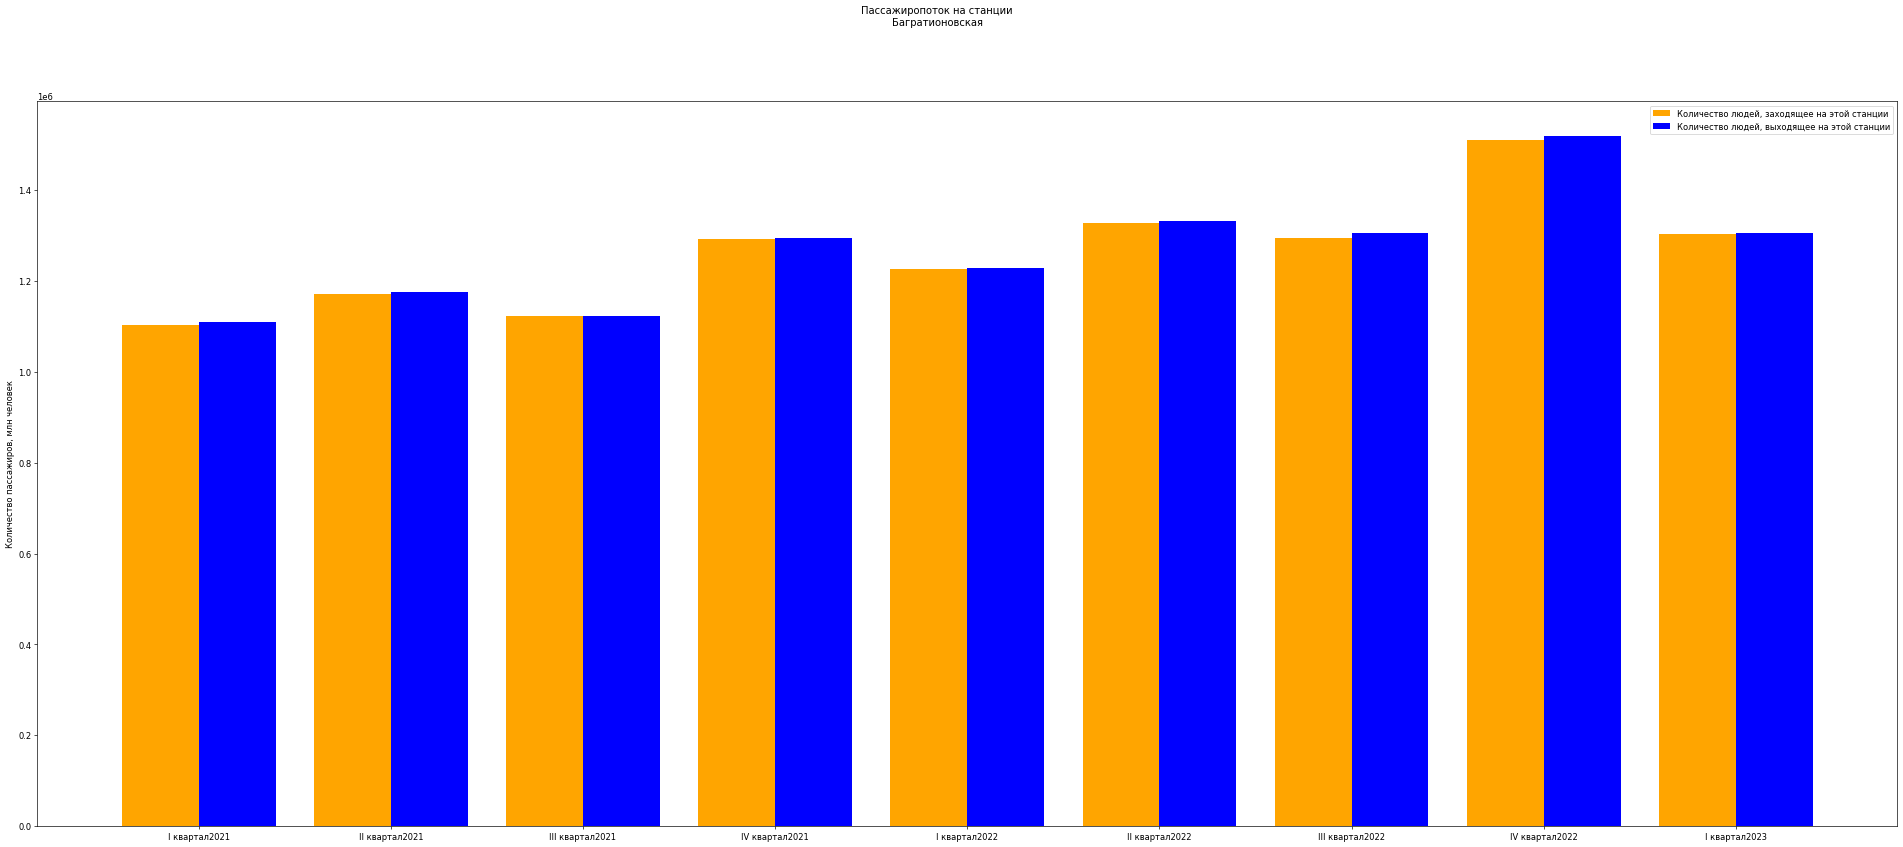

Данная станция сейчас занимает 3 место по входящему пассажиропотоку на Филёвская линия
Данная станция сейчас занимает 3 место по выходящему пассажиропотоку на Филёвская линия
Данная станция сейчас занимает 173 место по входящему пассажиропотоку и 176 по выходящему среди всех станций


In [10]:
interactive_passengers()

## Шаг 3: собираем данные для построения карты Москвы

Теперь соберем геоданные по стациям, чтобы построить карту московского метрополитена (к сожалению, геоданные включают в себя все входы и выходы станций, это нужно будет учесть в дальнейшем) . Для этого воспользуемся апи открытого портала данных Правительства Москвы.

##### Перед запуском кода вставить ссылку с ключом api

In [11]:
req = requests.get(" ")
response_json=req.json()
response_json_norm =json_normalize(response_json)
response_json_norm.head()

/var/folders/dv/b6_v0m4n46j_wcfy49_l_bp00000gn/T/ipykernel_8079/3595768650.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  response_json_norm =json_normalize(response_json)


,global_id,Number,Cells.is_deleted,Cells.system_object_id,Cells.ID,Cells.Name,Cells.OnTerritoryOfMoscow,Cells.AdmArea,Cells.District,Cells.Longitude_WGS84,...,Cells.ModeOnOddDays,Cells.FullFeaturedBPAAmount,Cells.LittleFunctionalBPAAmount,Cells.BPAAmount,Cells.RepairOfEscalators,Cells.ObjectStatus,Cells.global_id,Cells.signature_date,Cells.geoData.coordinates,Cells.geoData.type
0,1773539,1,0,331,331,"Китай-город, вход-выход 5 в северный вестибюль",да,Центральный административный округ,Басманный район,37.6316766,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,"[{'is_deleted': 0, 'RepairOfEscalators': '27.0...",действует,1773539,21.04.2023 13:58:45,"[37.6316766, 55.7573154]",Point
1,1773540,2,0,327,327,"Китай-город, вход-выход 4 в северный вестибюль",да,Центральный административный округ,Тверской район,37.631205,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,"[{'is_deleted': 0, 'RepairOfEscalators': '27.0...",действует,1773540,21.04.2023 13:58:45,"[37.631205, 55.756855]",Point
2,1773541,3,0,330,330,"Китай-город, вход-выход 6 в северный вестибюль",да,Центральный административный округ,Басманный район,37.6319506,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,"[{'is_deleted': 0, 'RepairOfEscalators': '27.0...",действует,1773541,21.04.2023 13:58:45,"[37.6319506, 55.7572362]",Point
3,1773542,4,0,322,322,"Китай-город, вход-выход 14 в южный вестибюль",да,Центральный административный округ,Тверской район,37.633082,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,[],действует,1773542,02.12.2022 15:55:10,"[37.633082, 55.753098]",Point
4,1773543,5,0,321,321,"Китай-город, вход-выход 12 в южный вестибюль",да,Центральный административный округ,Таганский район,37.633559,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,[],действует,1773543,02.12.2022 15:55:51,"[37.633559, 55.753072]",Point


In [12]:
#немного преобразуем данные
df_enters = response_json_norm[['Cells.geoData.coordinates','Cells.Name','Cells.Line']]
df_enters = df_enters.rename(columns = {'Cells.Name':'NameOfStation', 'Cells.Line':'Line'})

In [13]:
df_enters.head()

,Cells.geoData.coordinates,NameOfStation,Line
0,"[37.6316766, 55.7573154]","Китай-город, вход-выход 5 в северный вестибюль",Калужско-Рижская линия
1,"[37.631205, 55.756855]","Китай-город, вход-выход 4 в северный вестибюль",Калужско-Рижская линия
2,"[37.6319506, 55.7572362]","Китай-город, вход-выход 6 в северный вестибюль",Калужско-Рижская линия
3,"[37.633082, 55.753098]","Китай-город, вход-выход 14 в южный вестибюль",Калужско-Рижская линия
4,"[37.633559, 55.753072]","Китай-город, вход-выход 12 в южный вестибюль",Калужско-Рижская линия


In [14]:
#скачаем карту Москвы через geopandas, как было сделано в лекции
adm_moscow = gpd.read_file("http://gis-lab.info/data/mos-adm/mo.geojson")

<AxesSubplot:>

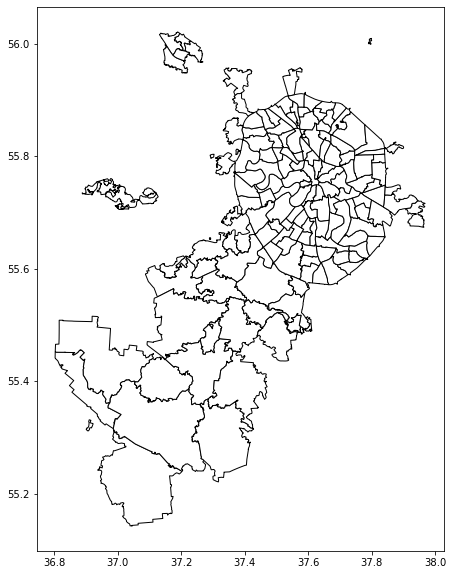

In [15]:
#изобразим на карте, проверим, что все хорошо загрузилось
adm_moscow.plot(
    color="white",
    edgecolor="black",
    figsize=(15, 10)
)

In [16]:
#преобразуем в точки координаты станций метро
metro_points = [Point(row) for row in df_enters['Cells.geoData.coordinates'].values]
df_enters['geometry'] = metro_points
df_enters.head()

,Cells.geoData.coordinates,NameOfStation,Line,geometry
0,"[37.6316766, 55.7573154]","Китай-город, вход-выход 5 в северный вестибюль",Калужско-Рижская линия,POINT (37.6316766 55.7573154)
1,"[37.631205, 55.756855]","Китай-город, вход-выход 4 в северный вестибюль",Калужско-Рижская линия,POINT (37.631205 55.756855)
2,"[37.6319506, 55.7572362]","Китай-город, вход-выход 6 в северный вестибюль",Калужско-Рижская линия,POINT (37.6319506 55.7572362)
3,"[37.633082, 55.753098]","Китай-город, вход-выход 14 в южный вестибюль",Калужско-Рижская линия,POINT (37.633082 55.753098)
4,"[37.633559, 55.753072]","Китай-город, вход-выход 12 в южный вестибюль",Калужско-Рижская линия,POINT (37.633559 55.753072)


In [17]:
#теперь преобразовываем таблицу со станциями метро в формат геопандаса
obj_gdf = gpd.GeoDataFrame(df_enters)

## Шаг 4: карта Москвы со станциями метро 1.0

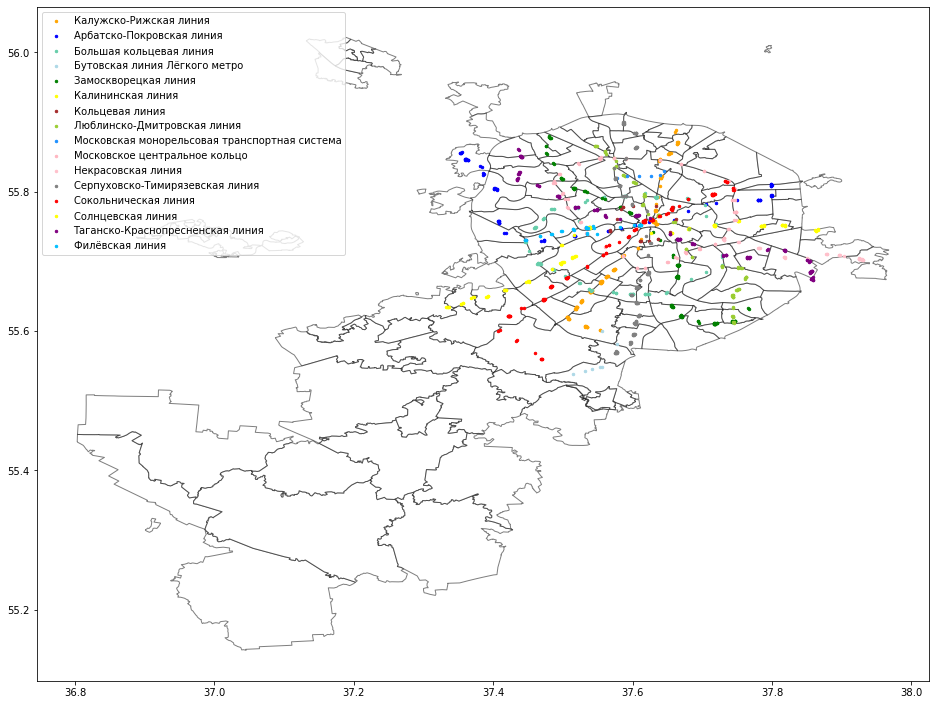

In [18]:
#строим карту (где настроим нужные цвета, как на реальной карте метро)
fig, ax = plt.subplots(figsize=(16,16))
adm_moscow.plot(ax=ax, alpha=0.5,color='white', edgecolor="black")
obj_gdf[obj_gdf['Line'] == 'Калужско-Рижская линия'].plot(ax=ax,color = 'orange', markersize=6, label = 'Калужско-Рижская линия')
obj_gdf[obj_gdf['Line'] == 'Арбатско-Покровская линия'].plot(ax=ax,color = 'blue', markersize=6, label = 'Арбатско-Покровская линия')
obj_gdf[obj_gdf['Line'] == 'Большая кольцевая линия'].plot(ax=ax,color = 'mediumaquamarine', markersize=6, label = 'Большая кольцевая линия')
obj_gdf[obj_gdf['Line'] == 'Бутовская линия Лёгкого метро'].plot(ax=ax,color = 'lightblue', markersize=6, label = 'Бутовская линия Лёгкого метро')
obj_gdf[obj_gdf['Line'] == 'Замоскворецкая линия'].plot(ax=ax,color = 'green', markersize=6, label ='Замоскворецкая линия')
obj_gdf[obj_gdf['Line'] == 'Калининская линия'].plot(ax=ax,color = 'yellow', markersize=6, label = 'Калининская линия')
obj_gdf[obj_gdf['Line'] == 'Кольцевая линия'].plot(ax=ax,color = 'brown', markersize=6, label = 'Кольцевая линия')
obj_gdf[obj_gdf['Line'] == 'Люблинско-Дмитровская линия'].plot(ax=ax,color = 'yellowgreen', markersize=6, label = 'Люблинско-Дмитровская линия')
obj_gdf[obj_gdf['Line'] == 'Московская монорельсовая транспортная система'].plot(ax=ax,color = 'dodgerblue', markersize=6, label =  'Московская монорельсовая транспортная система')
obj_gdf[obj_gdf['Line'] == 'Московское центральное кольцо'].plot(ax=ax,color = 'lightpink', markersize=6, label = 'Московское центральное кольцо')
obj_gdf[obj_gdf['Line'] == 'Некрасовская линия'].plot(ax=ax,color = 'pink', markersize=6, label = 'Некрасовская линия')
obj_gdf[obj_gdf['Line'] == 'Серпуховско-Тимирязевская линия'].plot(ax=ax,color = 'grey', markersize=6, label = 'Серпуховско-Тимирязевская линия')
obj_gdf[obj_gdf['Line'] == 'Сокольническая линия'].plot(ax=ax,color = 'red', markersize=6, label = 'Сокольническая линия')
obj_gdf[obj_gdf['Line'] == 'Солнцевская линия'].plot(ax=ax,color = 'yellow', markersize=6, label = 'Солнцевская линия')
obj_gdf[obj_gdf['Line'] == 'Таганско-Краснопресненская линия'].plot(ax=ax,color = 'purple', markersize=6, label = 'Таганско-Краснопресненская линия' )
obj_gdf[obj_gdf['Line'] == 'Филёвская линия'].plot(ax=ax,color = 'deepskyblue', markersize=6, label = 'Филёвская линия')
plt.legend()

Видим, что расположение станций совпадает с реальным расположением + все станции отображаются

Еще немного преобразуем данные, выделив конкретные районы и станции.

In [19]:
df_enters_1 = response_json_norm[['Cells.Name','Cells.Line', 'Cells.geoData.coordinates', 'Cells.District']]
df_enters_1 = df_enters_1.rename(columns = {'Cells.Name':'NameOfStation', 'Cells.Line':'Line', 'Cells.Longitude_WGS84':'Longitude','Cells.Latitude_WGS84':'Latitude','Cells.District':'District'})

In [20]:
df_enters_1.head()

,NameOfStation,Line,Cells.geoData.coordinates,District
0,"Китай-город, вход-выход 5 в северный вестибюль",Калужско-Рижская линия,"[37.6316766, 55.7573154]",Басманный район
1,"Китай-город, вход-выход 4 в северный вестибюль",Калужско-Рижская линия,"[37.631205, 55.756855]",Тверской район
2,"Китай-город, вход-выход 6 в северный вестибюль",Калужско-Рижская линия,"[37.6319506, 55.7572362]",Басманный район
3,"Китай-город, вход-выход 14 в южный вестибюль",Калужско-Рижская линия,"[37.633082, 55.753098]",Тверской район
4,"Китай-город, вход-выход 12 в южный вестибюль",Калужско-Рижская линия,"[37.633559, 55.753072]",Таганский район


In [21]:
# применим регулярное выражение, чтобы выделить название станции из колонки NameOfStation
h = []
df_enters_1['NameOfStationNormal'] = ''
import re
for i in range(len(df_enters_1)): 
    normal_name = re.search(r'[\w\.\s\-]+',df_enters_1['NameOfStation'].iloc[i])
    if normal_name is not None:
        #h.append(normal_name.group(0))
        df_enters_1['NameOfStationNormal'].iloc[i] = normal_name.group(0)

In [22]:
df_enters_1.head()

,NameOfStation,Line,Cells.geoData.coordinates,District,NameOfStationNormal
0,"Китай-город, вход-выход 5 в северный вестибюль",Калужско-Рижская линия,"[37.6316766, 55.7573154]",Басманный район,Китай-город
1,"Китай-город, вход-выход 4 в северный вестибюль",Калужско-Рижская линия,"[37.631205, 55.756855]",Тверской район,Китай-город
2,"Китай-город, вход-выход 6 в северный вестибюль",Калужско-Рижская линия,"[37.6319506, 55.7572362]",Басманный район,Китай-город
3,"Китай-город, вход-выход 14 в южный вестибюль",Калужско-Рижская линия,"[37.633082, 55.753098]",Тверской район,Китай-город
4,"Китай-город, вход-выход 12 в южный вестибюль",Калужско-Рижская линия,"[37.633559, 55.753072]",Таганский район,Китай-город


In [23]:
# еще раз преобразуем в точки координаты станций метро
metro_points_1 = [Point(row) for row in df_enters_1['Cells.geoData.coordinates'].values]
df_enters_1['geometry'] = metro_points_1

In [24]:
df_enters_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   NameOfStation              1089 non-null   object
 1   Line                       1089 non-null   object
 2   Cells.geoData.coordinates  1089 non-null   object
 3   District                   1078 non-null   object
 4   NameOfStationNormal        1089 non-null   object
 5   geometry                   1089 non-null   object
dtypes: object(6)
memory usage: 51.2+ KB


Видим, что не у всех станций промечается район. Это происходит потому, что некоторые станции находятся на территории Подмосковья.

Для дальнейшего анализа будет удобнее убрать слово 'район' из колонки District, чтобы соединить таблицы.

In [25]:
df_enters_2 = df_enters_1[df_enters_1['District'].isna() == False].copy().reset_index(drop=True)
df_enters_2.tail()

,NameOfStation,Line,Cells.geoData.coordinates,District,NameOfStationNormal,geometry
1073,"Аминьевская, вход-выход 1 в 1-й вестибюль",Большая кольцевая линия,"[37.46850848, 55.69650668]",район Раменки,Аминьевская,POINT (37.46850848 55.69650668)
1074,"Аминьевская, вход-выход 2 в 1-й вестибюль",Большая кольцевая линия,"[37.46728003, 55.69685813]",район Очаково-Матвеевское,Аминьевская,POINT (37.46728003 55.69685813)
1075,"Царицыно, вход-выход 7 в северный вестибюль",Замоскворецкая линия,"[37.66893328, 55.622433]",район Царицыно,Царицыно,POINT (37.66893328 55.622433)
1076,"Аминьевская, вход-выход 5 в 1-й вестибюль",Большая кольцевая линия,"[37.46504374, 55.69583171]",район Очаково-Матвеевское,Аминьевская,POINT (37.46504374 55.69583171)
1077,"Аминьевская, вход-выход 6 в 1-й вестибюль",Большая кольцевая линия,"[37.46298735, 55.69597411]",район Очаково-Матвеевское,Аминьевская,POINT (37.46298735 55.69597411)


In [26]:
#преобразовываем колонку с районом
list_region = []
list_each = []
stroka = ''
for i in range(len(df_enters_2)):
    list_each = df_enters_2['District'].iloc[i].split()
    for j in list_each:
        if j != 'район':
            stroka += ' ' + j
        else:
            continue
    list_region.append(stroka)
    stroka = ''
df_enters_2['District_normal'] = pd.Series(list_region)
for k in range(len(df_enters_2)):
    df_enters_2['District_normal'].iloc[k] = df_enters_2['District_normal'].iloc[k].strip()

### Таблицы на данный момент:
* adm_moscow - администротивно-территориальное устройство районов Москвы, координаты районов.
* metro_pas - данные о пассажиропотоках на разных станциях метро с 2021 года
* df_enters_2 - преобразованная таблица с выходами со станций метро, координатами и районами, где расположены данные станции

## Шаг 5: парсинг данных о наслении районов Москвы, где расположены станции

Спарсим данные о Московских округах и численности населения с Википедии - https://ru.wikipedia.org/wiki/Районы_и_поселения_Москвы , чтобы добавить эти данные на карту, а также посмотреть, как пассажиропоток зависит от население района. К сожалению, данных по населению около каждой станции не было, поэтому в данном случае возникнет такая ситуация, что у нескольких станций, расположенных в одном районе, будут одинаковые данные по населению.

In [27]:
req_1 = requests.get("https://ru.wikipedia.org/wiki/Районы_и_поселения_Москвы")
soup = BeautifulSoup(req_1.text,'lxml')

In [28]:
#сначала спарсим заголовки нашей таблицы (они немного странно отражаются из-за самого формата на википедии)
headers = []
for th in soup.find_all('th'):
    headers.append(th.text.strip())

In [29]:
#спарсим значения из таблицы
data = []
for tr in soup.find_all('tr')[1:]:
    row = []
    for td in tr.find_all('td'):
        row.append(td.text.strip())
    data.append(row)

In [30]:
#добавим все в датафрейм
data_regions = pd.DataFrame(columns=headers)
for i in range(len(data)):
    df_row_1_region = pd.Series(data[i], index=data_regions.columns)
    data_regions = pd.concat([data_regions, df_row_1_region.to_frame().T], ignore_index=True)


In [31]:
#преобразуем данные понаселению опять же с помощью регулярных выражений
data_regions['Насе-ление2023[8],чел.'] = data_regions['Насе-ление2023[8],чел.'].str.replace(r'[^\d+]','')

/var/folders/dv/b6_v0m4n46j_wcfy49_l_bp00000gn/T/ipykernel_8079/2241616185.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data_regions['Насе-ление2023[8],чел.'] = data_regions['Насе-ление2023[8],чел.'].str.replace(r'[^\d+]','')


In [32]:
data_regions.head()

,№,Флаг,Герб,Название района[2]/поселения[3][4],Название cоответствующего внутригородского муниципального образования: муниципального округа / поселения / городского округа[5],Адми-нистра-тивныйокруг,"Пло-щадь,[6][7]км²","Насе-ление2023[8],чел.","Плот-ностьнасе-ления2023,чел. / км²","Пло-щадьжилого фонда(01.01.2010)[9],тыс. м²","Жил-площадьначело-века(01.01.2010),м²/чел."
0,1,,,Академический,Академический,ЮЗАО,"5,83",113198,19416.47,"2467,0","22,7"
1,2,,,Алексеевский,Алексеевский,СВАО,"5,29",78502,14839.7,"1607,9","20,5"
2,3,,,Алтуфьевский,Алтуфьевский,СВАО,"3,25",55753,17154.77,"839,3","15,5"
3,4,,,Арбат,Арбат,ЦАО,"2,11",35962,17043.6,"731,0","26,0"
4,5,,,Аэропорт,Аэропорт,САО,"4,58",81964,17896.07,"1939,7","25,9"


In [33]:
# преобразуем названия колонок, чтобы удобно было обращаться к ним
data_regions = data_regions.rename(columns = {'Название cоответствующего внутригородского муниципального образования: муниципального округа / поселения / городского округа[5]':'Район',
                                              'Адми-нистра-тивныйокруг':'Административный округ',
                                              'Пло-щадь,[6][7]км²':'Площадь',
                                              'Насе-ление2023[8],чел.':'Население',
                                              'Плот-ностьнасе-ления2023,чел. / км²':'Плотность населения',
                                              'Пло-щадьжилого фонда(01.01.2010)[9],тыс. м²':'Площадь жилого фонда',
                                              'Жил-площадьначело-века(01.01.2010),м²/чел.':'Жилплощадь на человека'})
data_regions = data_regions[['Район','Административный округ','Площадь','Население', 'Плотность населения','Площадь жилого фонда','Жилплощадь на человека']]

In [34]:
data_regions.head()

,Район,Административный округ,Площадь,Население,Плотность населения,Площадь жилого фонда,Жилплощадь на человека
0,Академический,ЮЗАО,"5,83",113198,19416.47,"2467,0","22,7"
1,Алексеевский,СВАО,"5,29",78502,14839.7,"1607,9","20,5"
2,Алтуфьевский,СВАО,"3,25",55753,17154.77,"839,3","15,5"
3,Арбат,ЦАО,"2,11",35962,17043.6,"731,0","26,0"
4,Аэропорт,САО,"4,58",81964,17896.07,"1939,7","25,9"


Ранее мы создали таблицу с информацией о выходых со станций метро и их координатами, теперь из этой таблицы оставим только линию метро, название станции и район, в котором она расположена, чтобы объединить таблицы и получить нужную нам информацию.

Важно: некоторые выходы станций метро расположены в разных районах (например, выходы станции "Китай-город"), поэтому на одну станцию может приходиться несколько строчек

In [35]:
df_enters_2 = df_enters_2[['Line','NameOfStationNormal','District_normal']]
df_enters_2 = df_enters_2.drop_duplicates().reset_index(drop=True)
df_enters_2.head()

,Line,NameOfStationNormal,District_normal
0,Калужско-Рижская линия,Китай-город,Басманный
1,Калужско-Рижская линия,Китай-город,Тверской
2,Калужско-Рижская линия,Китай-город,Таганский
3,Калужско-Рижская линия,Калужская,Коньково
4,Люблинско-Дмитровская линия,Братиславская,Марьино


Теперь, когда предварительная обработка данных завершена, можно объединить таблицы со станциями, районами, населением районов, пассажиропотоками, чтобы проверить, как коррелирует пассажиропоток с районом, где расположено метро, населением и т.д.

Для этого создадим базу данных в sql и сделаем join там, для удобства оставим данные только за первый квартал 2023 года.

Также, обучим модель, которая будет предсказывать пассажиропоток.

## Шаг 6: создание базы данных с имеющимися таблицами в sql

In [36]:
import sqlite3

In [37]:
connection = sqlite3.connect("my_db_1.sqlite")
cursor = connection.cursor()

In [38]:
#таблица со станциями и их районами
cursor.executescript("""
drop table if exists Station_plus_region;
CREATE TABLE Station_plus_region (
    Line text,
    NameOfStationNormal text,
    District_normal text PRIMARY KEY
)
""")

In [39]:
connection.commit()

In [40]:
df_enters_2.to_sql('Station_plus_region', connection, if_exists='replace', index=False)

362

In [41]:
#таблица с районами из википедии с данными по населению
cursor.executescript("""
drop table if exists region;
CREATE TABLE region (
    Район text PRIMARY KEY,
    Административный округ text,
    Площадь real,
    Население real,
    Плотность населения real,
    Площадьжилого фонда real,
    Жилплощадь на человека real
)
""")

In [42]:
data_regions.to_sql('region', connection, if_exists='replace', index=False)

146

In [43]:
# таблица с пассажиропотоками (самая первая в проекте)
cursor.executescript("""
drop table if exists stations_plus_passengeers;
CREATE TABLE stations_plus_passengeers (
    NameOfStation text PRIMARY KEY,
    Line text,
    Year text,
    Quarter text,
    IncomingPassengers int,
    OutgoingPassengers int,
    Yearandquarter text
)
""")

In [44]:
metro_pas.to_sql('stations_plus_passengeers', connection, if_exists='replace', index=False)

2520

In [45]:
# таблица с геоданными о московских районах
cursor.executescript("""
drop table if exists geo_regions;
CREATE TABLE geo_regions (
    NAME text PRIMARY KEY,
    geometry text
)
""")

In [46]:
adm_moscow['geometry'] = adm_moscow['geometry'].astype('str')

/Users/tatianasoboleva/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1537: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [47]:
adm_moscow[['NAME','geometry']].to_sql('geo_regions', connection, if_exists='replace', index=False)

146

In [48]:
#объединяем все имеющиеся данные
cursor.executescript("""
drop table if exists station_region_data;
create table station_region_data as
select distinct
    t1.*,
    t2.District_normal,
    t3.*,
    t4.geometry
    from
        stations_plus_passengeers as t1
        left join Station_plus_region as t2
        on true
        and t1.NameOfStation = t2.NameOfStationNormal
        left join region as t3
        on true
        and t3.Район = t2.District_normal
        left join geo_regions as t4
        on true
        and t3.Район = t4.NAME
        where true
        and t1.Year = '2023';
"""
)

In [49]:
final_table = pd.read_sql("SELECT * FROM station_region_data",connection)

In [50]:
connection.close()

In [51]:
final_table.head()

,NameOfStation,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers,global_id,Year and quarter,District_normal,Район,Административный округ,Площадь,Население,Плотность населения,Площадь жилого фонда,Жилплощадь на человека,geometry
0,Пятницкое шоссе,Арбатско-Покровская линия,2023,I квартал,1513158,1424167,2581188693,I квартал2023,Митино,Митино,СЗАО,"12,67",197840,15614.84,"3658,1","21,0","POLYGON ((37.33204 55.84595, 37.33205 55.84598..."
1,Митино,Арбатско-Покровская линия,2023,I квартал,2077333,1992849,2581188695,I квартал2023,Митино,Митино,СЗАО,"12,67",197840,15614.84,"3658,1","21,0","POLYGON ((37.33204 55.84595, 37.33205 55.84598..."
2,Волоколамская,Арбатско-Покровская линия,2023,I квартал,1487085,1444993,2581188696,I квартал2023,Митино,Митино,СЗАО,"12,67",197840,15614.84,"3658,1","21,0","POLYGON ((37.33204 55.84595, 37.33205 55.84598..."
3,Мякинино,Арбатско-Покровская линия,2023,I квартал,1499235,1431843,2581188697,I квартал2023,None,None,None,None,None,None,None,None,None
4,Строгино,Арбатско-Покровская линия,2023,I квартал,2431426,2392189,2581188698,I квартал2023,Строгино,Строгино,СЗАО,"16,84",161980,9618.76,"2406,2","15,8","POLYGON ((37.36726 55.79036, 37.36784 55.79136..."


In [52]:
final_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   NameOfStation           375 non-null    object
 1   Line                    375 non-null    object
 2   Year                    375 non-null    object
 3   Quarter                 375 non-null    object
 4   IncomingPassengers      375 non-null    int64 
 5   OutgoingPassengers      375 non-null    int64 
 6   global_id               375 non-null    int64 
 7   Year and quarter        375 non-null    object
 8   District_normal         365 non-null    object
 9   Район                   358 non-null    object
 10  Административный округ  358 non-null    object
 11  Площадь                 358 non-null    object
 12  Население               358 non-null    object
 13  Плотность населения     358 non-null    object
 14  Площадь жилого фонда    358 non-null    object
 15  Жилпло

Видим, что в некоторых строчках не промечается район, это связано с тем, что станции располагются в Подмосковье (например, Митино и Мякинино)

Опять немного преобразуем данные с Википедии, так как нужно их перевести в числовой формат.

In [53]:
final_table['Площадь'] = final_table['Площадь'].str.replace(',', '.').astype('float')
final_table['Население'] = final_table['Население'].astype('float')
final_table['Плотность населения'] = final_table['Плотность населения'].astype('float')
final_table['Площадь жилого фонда'] = final_table['Площадь жилого фонда'].str.replace(',', '.').astype('float')
final_table['Жилплощадь на человека'] = final_table['Жилплощадь на человека'].str.replace(',', '.').astype('float')


In [54]:
final_table = final_table.drop(columns = 'global_id')

## Шаг 7: изучение зависимостей пассажиропотоков от плотностей населения районов

Теперь посмотрим, как пассажиропоток зависит от таких параметров, как население района, жилплощадь и т.д

<AxesSubplot:>

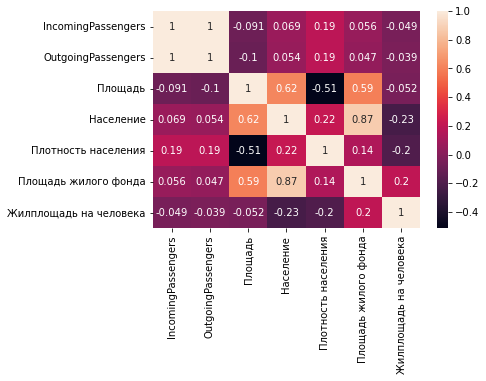

In [55]:
sns.heatmap(final_table.corr(), annot=True)

Видим, что количество пассажиров сильнее всего кореллирует с плотностью населения, что объяснимо

Посмотрим еще некоторые статистики по районам:

In [56]:
print("Средняя площадь:", np.mean(final_table['Площадь']))
print("Среднее значение населения района:", np.mean(final_table['Население']))

Средняя площадь: 8.722709497206695
Среднее значение населения района: 102711.07262569832


Построим теперь линейную регрессию, и посмотрим зависимость пассажиропотока от данных показателей + проверим гипотезу, о том, что на пассажиропоток также влияет то, является ли линия кольцевой, что в целом логично предположить.

In [57]:
#предварительная обработка данных
final_table = final_table[final_table.isnull().any(axis=1) == False]
final_table_ml = final_table
#преобразовываем категориальные переменные
final_table_ml = pd.get_dummies(final_table_ml, columns = ['Line'])
final_table_ml = final_table_ml.select_dtypes(include = 'number')
final_table_ml = final_table_ml[final_table_ml['IncomingPassengers'] != 0]


In [58]:
#колонка, определяющая является ли линия кольцевой
final_table_ml['iscurcle'] =np.where((final_table_ml['Line_Большая кольцевая линия'] == 1) | (final_table_ml['Line_Кольцевая линия'] == 1) | (final_table_ml['Line_Московское центральное кольцо'] == 1),1,0)

In [59]:
final_table_ml.head()

,IncomingPassengers,OutgoingPassengers,Площадь,Население,Плотность населения,Площадь жилого фонда,Жилплощадь на человека,Line_Арбатско-Покровская линия,Line_Большая кольцевая линия,Line_Бутовская линия Лёгкого метро,...,Line_Люблинско-Дмитровская линия,Line_Московская монорельсовая транспортная система,Line_Московское центральное кольцо,Line_Некрасовская линия,Line_Серпуховско-Тимирязевская линия,Line_Сокольническая линия,Line_Солнцевская линия,Line_Таганско-Краснопресненская линия,Line_Филёвская линия,iscurcle
0,1513158,1424167,12.67,197840.0,15614.84,3658.1,21.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2077333,1992849,12.67,197840.0,15614.84,3658.1,21.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1487085,1444993,12.67,197840.0,15614.84,3658.1,21.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2431426,2392189,16.84,161980.0,9618.76,2406.2,15.8,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2162578,2130423,12.04,82923.0,6887.29,1850.5,22.4,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Создадим две группы: train и test для дальнейшей проверки зависимостей.

In [97]:
y = final_table_ml['IncomingPassengers']
x = final_table_ml.drop(columns=['IncomingPassengers','OutgoingPassengers','Жилплощадь на человека','Площадь жилого фонда','Площадь'])
Xtrn, Xtest, Ytrn, Ytest = train_test_split(x, y, test_size=0.2)


In [98]:
model = LinearRegression().fit(Xtrn, Ytrn)

In [99]:
y_pred = model.predict(Xtest)
r2 = r2_score(Ytest, y_pred)
print("R-квадрат:", r2)
mse = mean_squared_error(Ytest, y_pred)
print("MSE:", mse)
# модель на данных обучается плохо, точность доходит до 0,4 и большая среднеквадратическая ошибка

R-квадрат: 0.5425166121901726
MSE: 837414757598.478


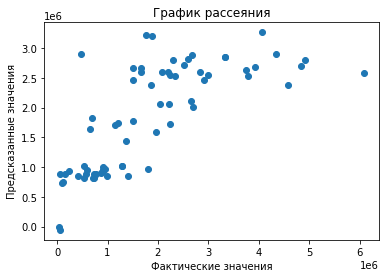

In [100]:
#построим график рассеяния
plt.scatter(Ytest, y_pred)
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.title("График рассеяния")
plt.show()


Посмотрим на коэффициенты регрессии и свободный член.

In [101]:
model.intercept_

1595188.7890239067

In [102]:
for i in range(len(x.columns)):
    print (x.columns[i],':', model.coef_[i])

Население : 0.5712353597783236
Плотность населения : 17.653934427275253
Line_Арбатско-Покровская линия : 687920.5855754807
Line_Большая кольцевая линия : -794788.9555703537
Line_Бутовская линия Лёгкого метро : -884542.2963369517
Line_Замоскворецкая линия : 697261.7337814193
Line_Калининская линия : 988124.301721246
Line_Калужско-Рижская линия : 814309.9558813821
Line_Кольцевая линия : 1273162.4808073568
Line_Люблинско-Дмитровская линия : -143235.10190776899
Line_Московская монорельсовая транспортная система : -1782426.0234243453
Line_Московское центральное кольцо : -685024.9080237675
Line_Некрасовская линия : -308117.38484569115
Line_Серпуховско-Тимирязевская линия : 554483.9915695381
Line_Сокольническая линия : 212887.79991002014
Line_Солнцевская линия : -929209.1251012804
Line_Таганско-Краснопресненская линия : 1358547.0516739218
Line_Филёвская линия : -1059354.105710209
iscurcle : -206651.38278676211


Сделаем то же самое с помощью модели "случайный лес"

In [103]:
rf = RandomForestRegressor(n_estimators=100,  max_depth=10, random_state=42)

In [104]:
rf.fit(Xtrn, Ytrn)

RandomForestRegressor(max_depth=10, random_state=42)

In [105]:
score = rf.score(Xtest, Ytest)
print('Accuracy:', score)

Accuracy: 0.5088260215814806


Видим, что в данном случае работает хуже + модель плохо обучается на этих данных

Причины:
* Для нескольких станций в данном случае одни и те же данные по населению района и плотности населения
* Данных мало, всего около 300 строк
* Много категориальных переменных, однако логистическую регрессию построить не получится, так как есть и другие типы переменных

Выводы по данным:

* Пассажиропоток кореллирует с населением и плотностью населения в районе, однако корелляция не очень сильная (причины описаны в конце проекта)
* Данные параметры не точно определяют пассажиропоток из-за того, что не уникальны для каждой станции + не объясняют все факторы: например, наличие инфраструктуры рядом со станциями, мест для досуга и т.д., что конечно же влияет на пассажиропоток

## Шаг 8: построение итоговой карты с пассажиропотоком для конкретной станции

Построим финальную карту, где можно будет выбрать станцию и будет отражаться пассажиропоток + учтем плотности населения районов. Для этого создадим граф, где его вершины - станции метро

In [60]:
metro_map = nx.Graph()

In [61]:
# прометим цвета в таблице, как на реальной карте
final_table['color'] = np.where(final_table['Line'] == 'Калужско-Рижская линия','orange',
                                np.where(final_table['Line']== 'Арбатско-Покровская линия','blue',
                                np.where(final_table['Line']== 'Большая кольцевая линия','mediumaquamarine',
                                np.where(final_table['Line']== 'Бутовская линия Лёгкого метро','lightblue',
                                np.where(final_table['Line']== 'Замоскворецкая линия','green',
                                np.where(final_table['Line']== 'Калининская линия','yellow',
                                np.where(final_table['Line']== 'Кольцевая линия','brown',
                                np.where(final_table['Line']== 'Люблинско-Дмитровская линия','yellowgreen',
                                np.where(final_table['Line']== 'Московская монорельсовая транспортная система','dodgerblue',
                                np.where(final_table['Line']== 'Московское центральное кольцо','lightpink',
                                np.where(final_table['Line']== 'Некрасовская линия','pink',
                                np.where(final_table['Line']== 'Серпуховско-Тимирязевская линия','grey',
                                np.where(final_table['Line']== 'Сокольническая линия','red',
                                np.where(final_table['Line']== 'Солнцевская линия','yellow',
                                np.where(final_table['Line']== 'Таганско-Краснопресненская линия','purple',
                                'deepskyblue'))))))))))))))
                               )

In [62]:
#теперь добавляем точки в граф
for index, row in final_table.iterrows():
    metro_map.add_node(str(row['NameOfStation']+ ', ' +row['Line']),weight = row['IncomingPassengers'], color = row['color'])

In [63]:
df_enters_1 = gpd.GeoDataFrame(df_enters_1)
final_table = gpd.GeoDataFrame(final_table)
final_table['geometry'] = loads(final_table['geometry'])
adm_moscow['geometry'] = loads(adm_moscow['geometry'])
final_table = final_table.set_geometry('geometry')
adm_moscow = adm_moscow.set_geometry('geometry')

Чтобы воспользоваться картой, не забудьте проверить написание названия линии и станции (как и на прошлом графике) для правильной работы кода.

In [71]:
# функции для отрисовки карты
def map_1(station,line):
    fig, ax = plt.subplots(figsize=(16,16))
    adm_moscow.plot(ax=ax, alpha=0.5,color='white', edgecolor="black")
    final_table.plot(ax=ax, column='Плотность населения', cmap='OrRd',alpha=0.5, edgecolor="black",legend=True)
    necessary_station = str(station +', '+line)
    passengers = nx.get_node_attributes(metro_map, 'weight')
    incomingpas = passengers[necessary_station]
    colors = nx.get_node_attributes(metro_map, 'color')
    colorpas = colors[necessary_station]
    need_to_plot = df_enters_1.loc[(df_enters_1['Line'] == line)&(df_enters_1['NameOfStationNormal'] == station)]
    need_to_plot.plot(ax=ax,color = colorpas, markersize=50)
    ax.annotate(f'{incomingpas}', xy = (need_to_plot.geometry.x.iloc[0],need_to_plot.geometry.y.iloc[0]),color='black',fontsize=25)
    fig.suptitle('Карта для станции' +'\n' + f'{station}')
    plt.show()

def final_map():
    print('Введите станцию:')
    station = input()
    if len(metro_pas['Line'][metro_pas['NameOfStation'] == station].unique()) > 1:
        print('Данная станция встречается на нескольких линиях, поэтому уточните название линии:')
        line_for_plot = input()
        if line_for_plot not in metro_pas['Line'].unique():
            raise Exception("Такой линии не существует или проверьте написание")
    elif len(metro_pas['Line'][metro_pas['NameOfStation'] == station].unique()) ==1:
        line_for_plot = metro_pas['Line'][metro_pas['NameOfStation'] == station].iloc[0]
    else:
        raise Exception("Такой станции не существует или введите повторно")
    map_1(station,line_for_plot)

Disclaimer: для некоторых пересадочных узлов карта может не строится, это связано с тем, что входы/выходы станций объединены и в исходных данных промечается только одна из двух станций. Если вдруг для какой-то станции не строится, то необходимо просто выбрать другую станцию в том же пересадочном узле (например, вместо Арбатской выбрать Александровский сад и т.д.)

Введите станцию:
Охотный ряд


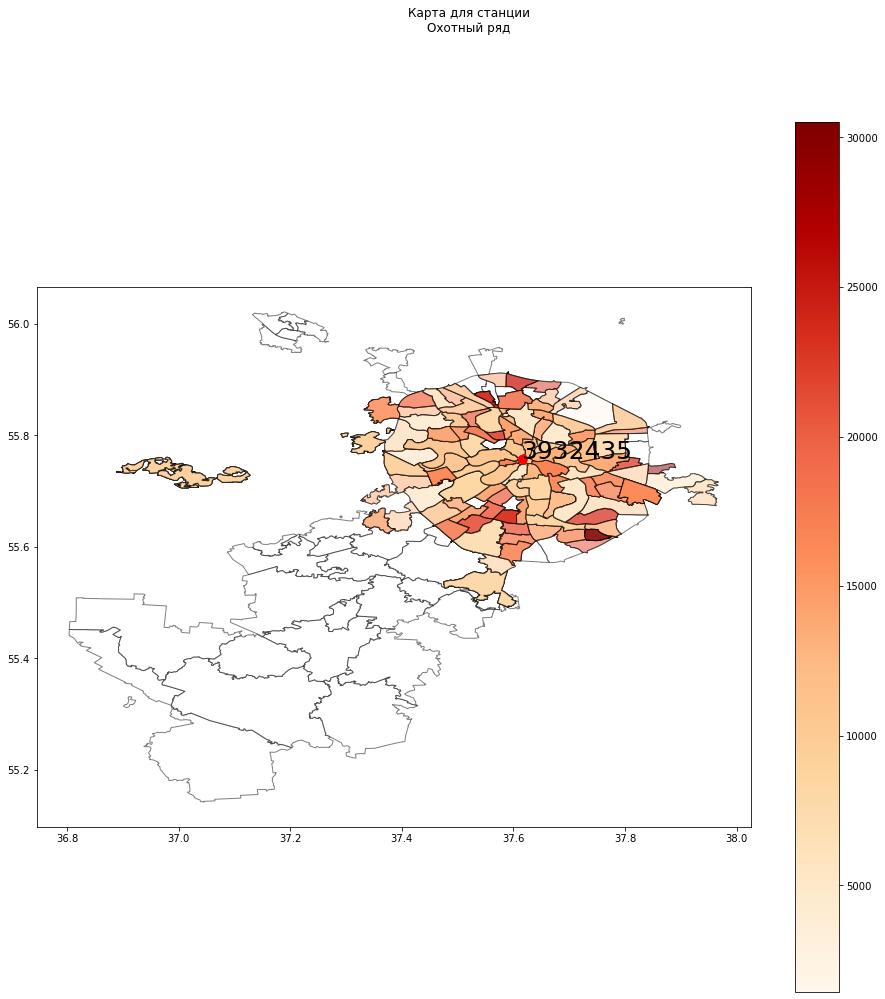

In [72]:
#сама карта (запускать можно много раз)
final_map()

Теперь можно для любой станции отслеживать пассажиропоток, а также смотреть на то, как он коррелирует с плотностью населения в данном районе с помощью карт. 

Изучив карту по различным станциям, можно увидеть
P.S. На самом деле, мы увидели низкую корелляцию из-за того, что в центре Москвы как раз плотность населения небольшая, а пассажиропоток огромный, что и снижает эффект. Однако, если брать только оркаины, то мы, вероятно, увидим высокую корелляцию.

И, наконец, изобразим топ 10 загруженных станций (тех, где входящий пассажиропоток наибольший)

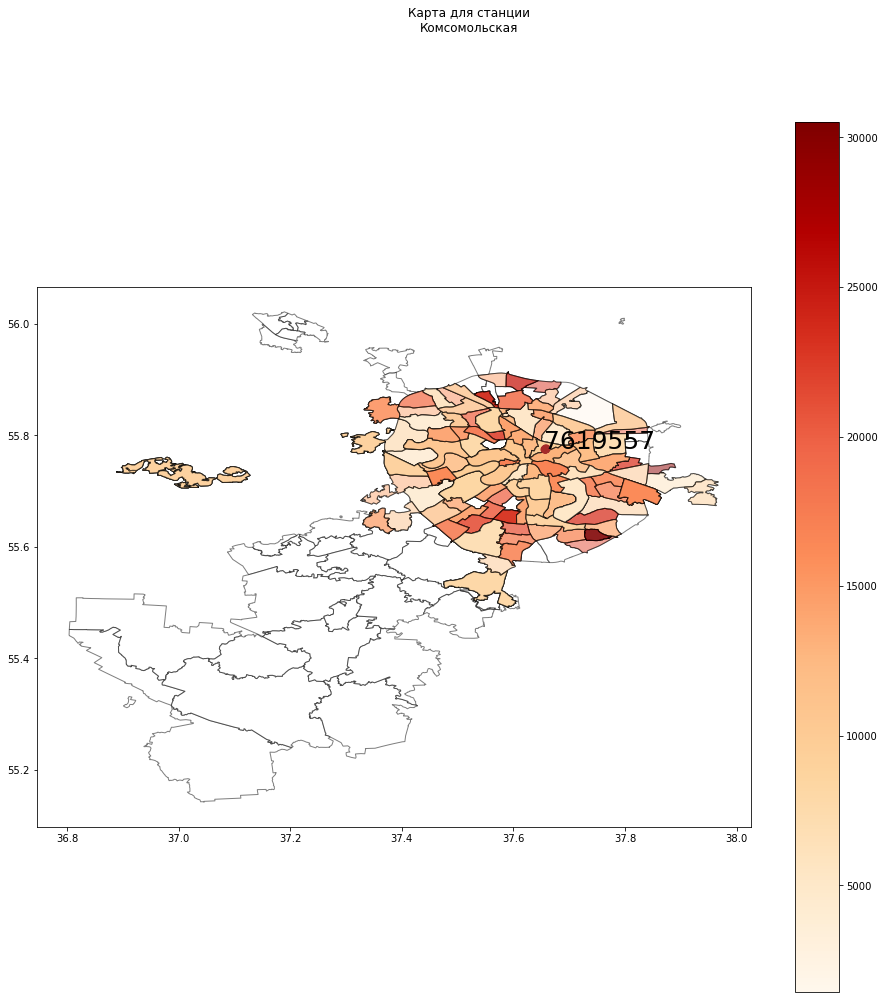

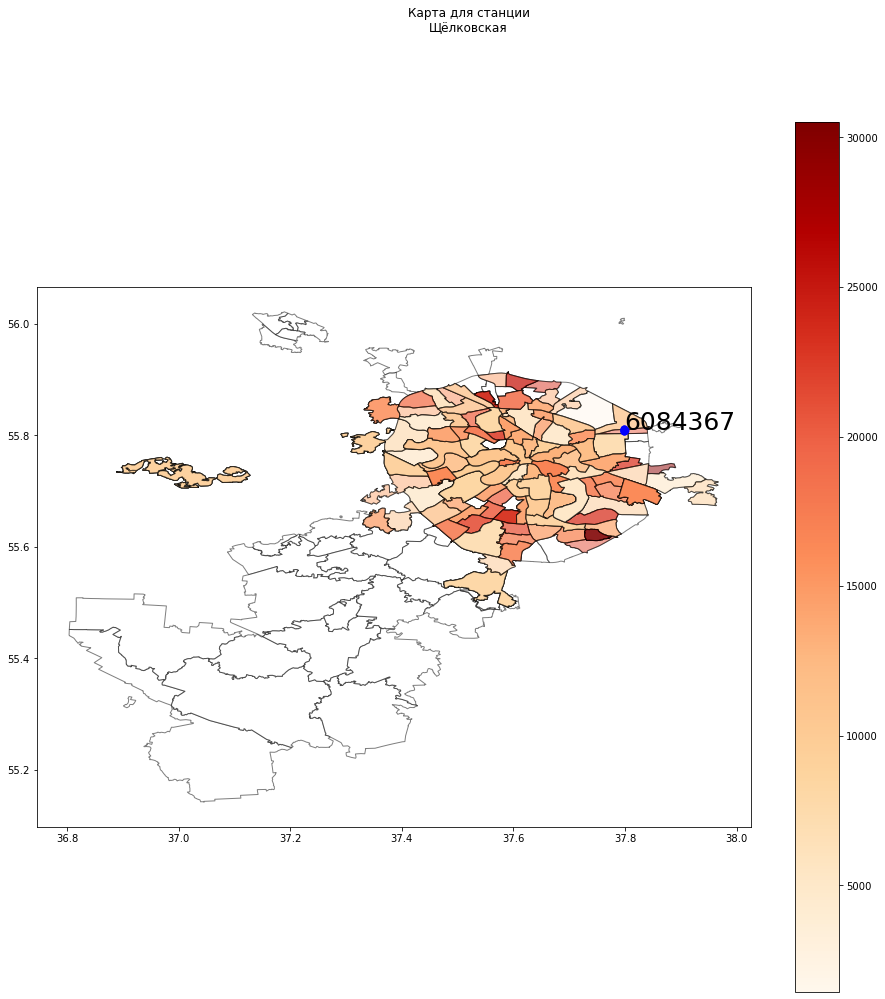

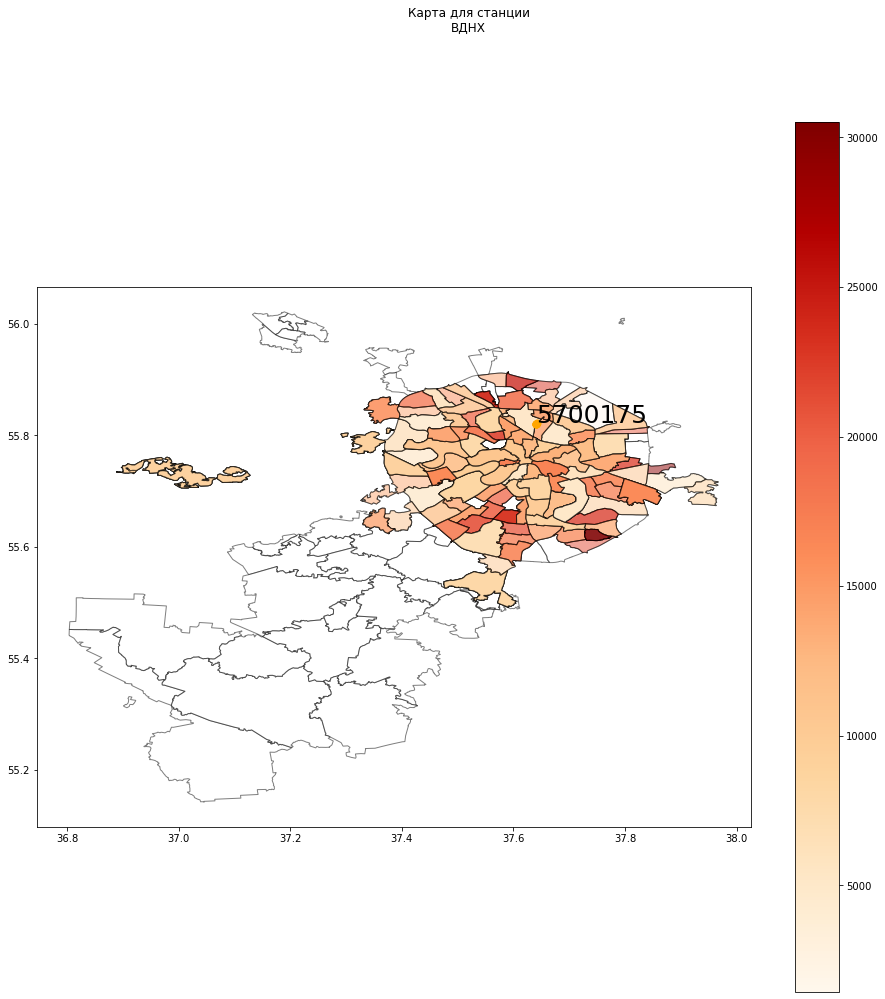

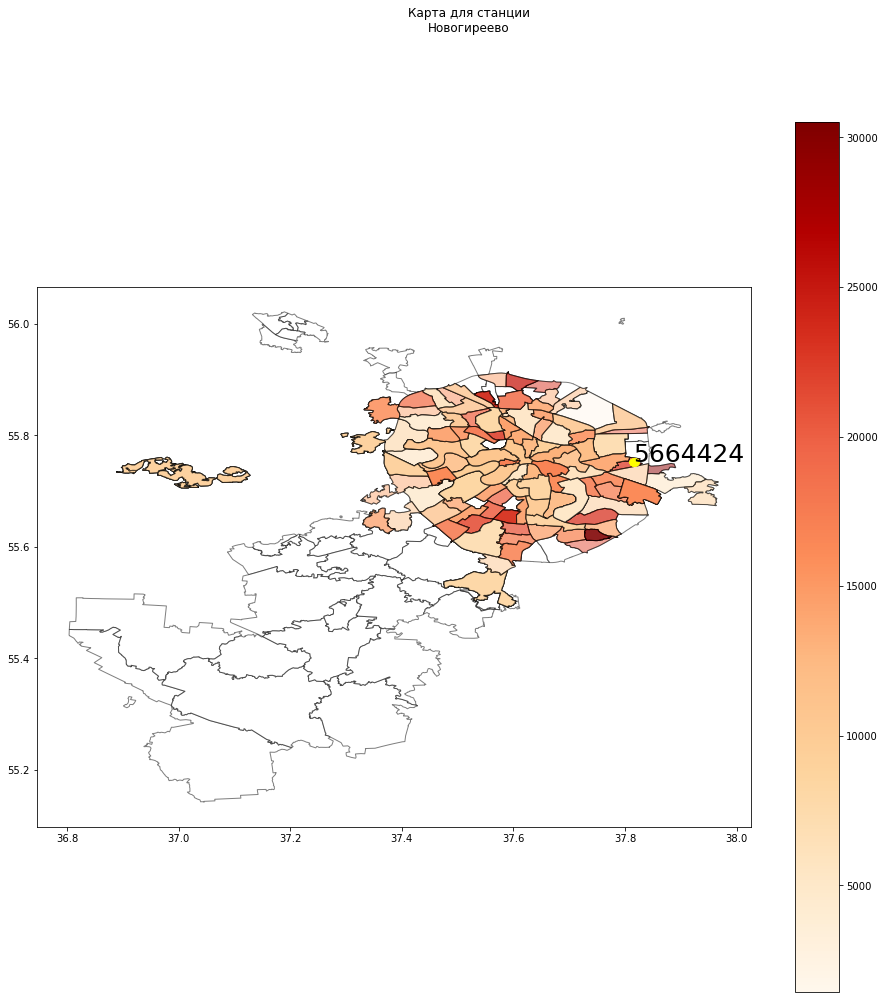

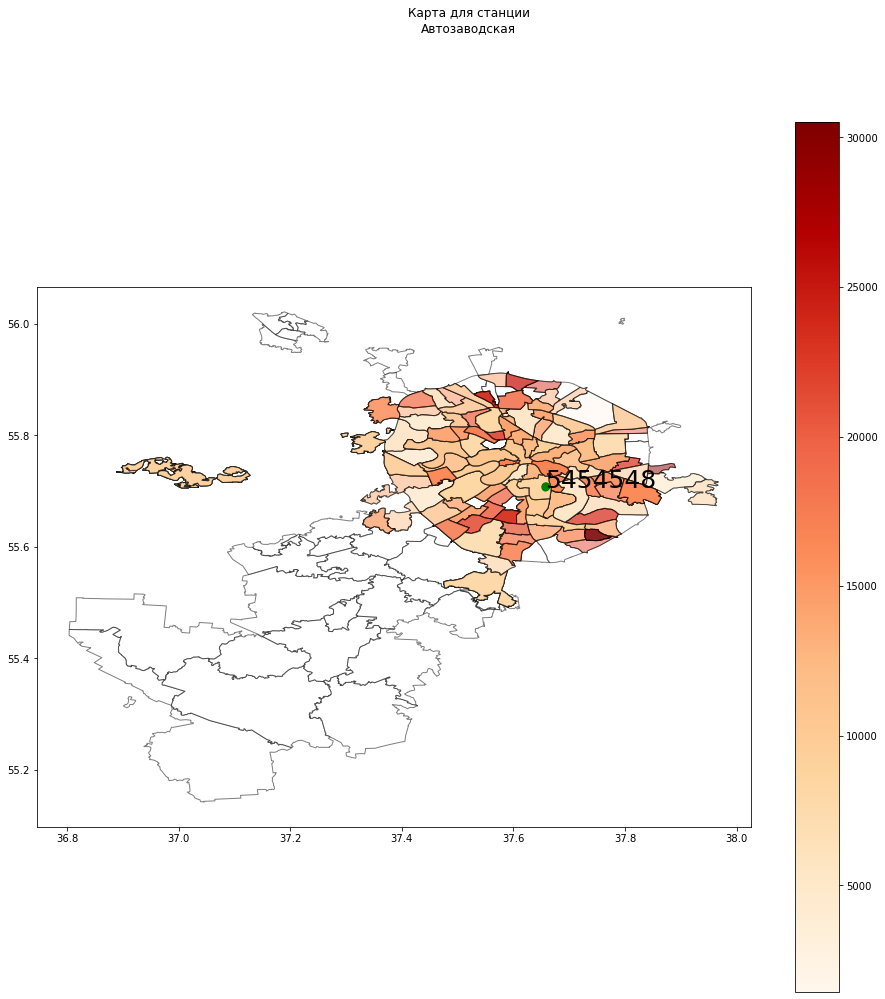

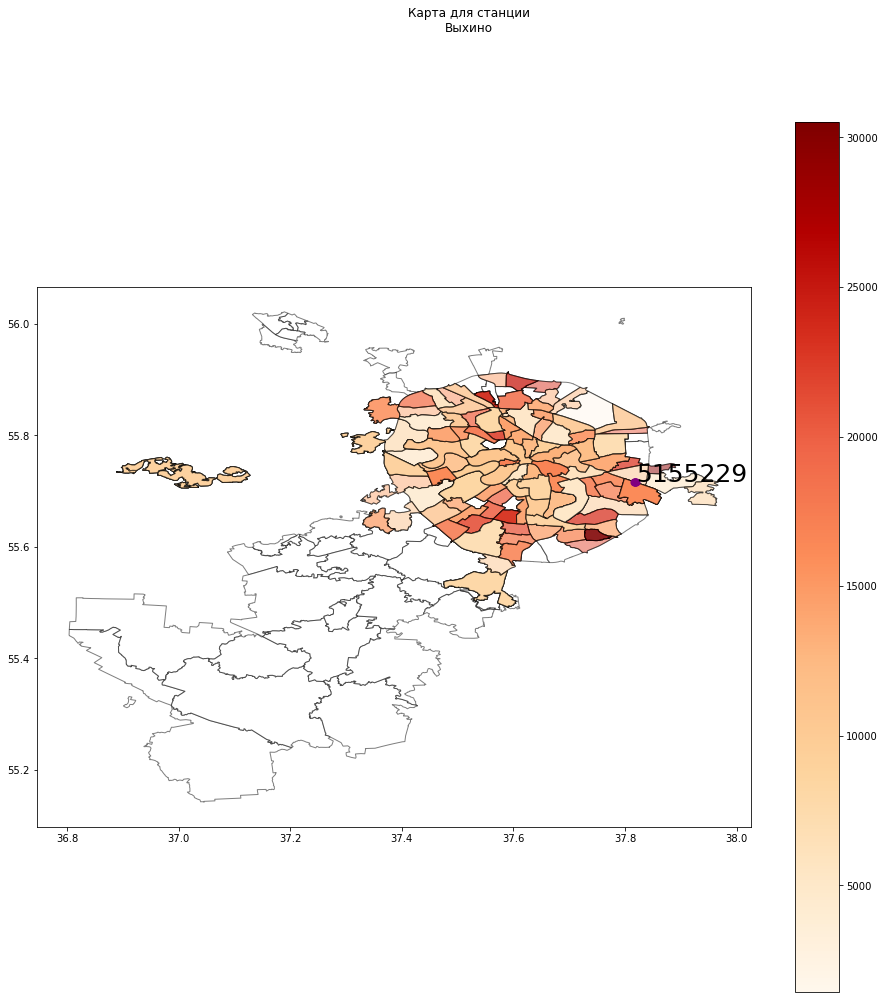

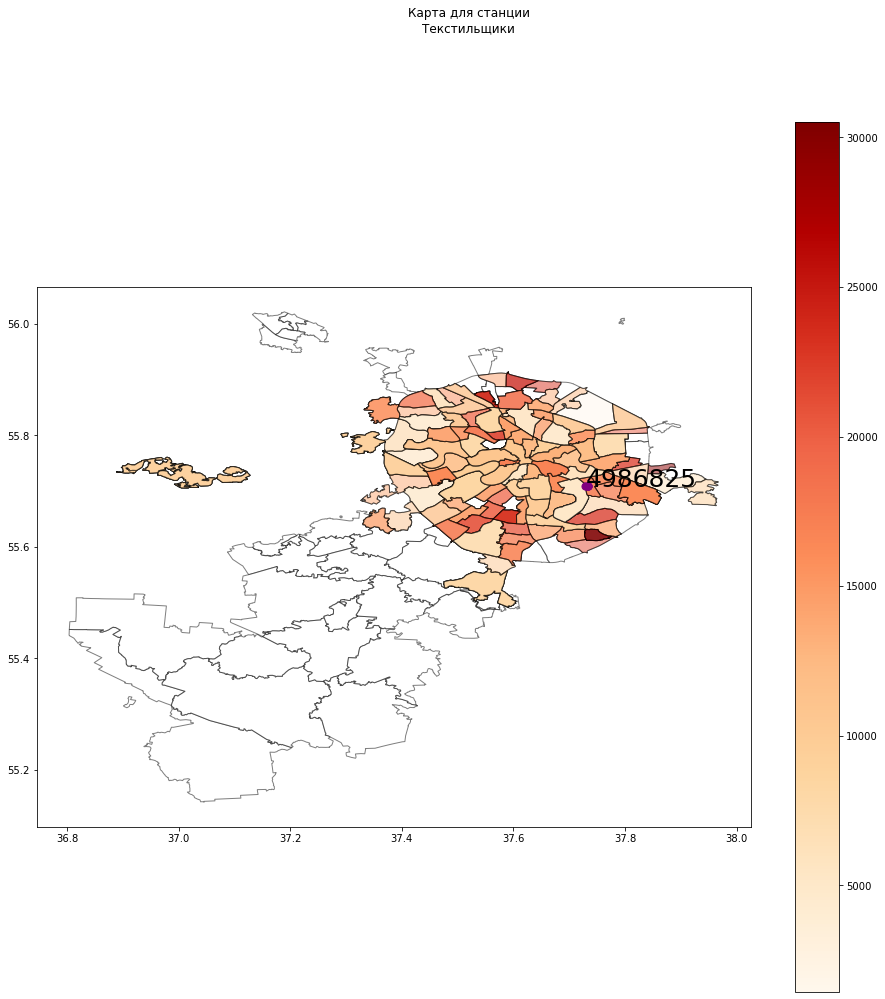

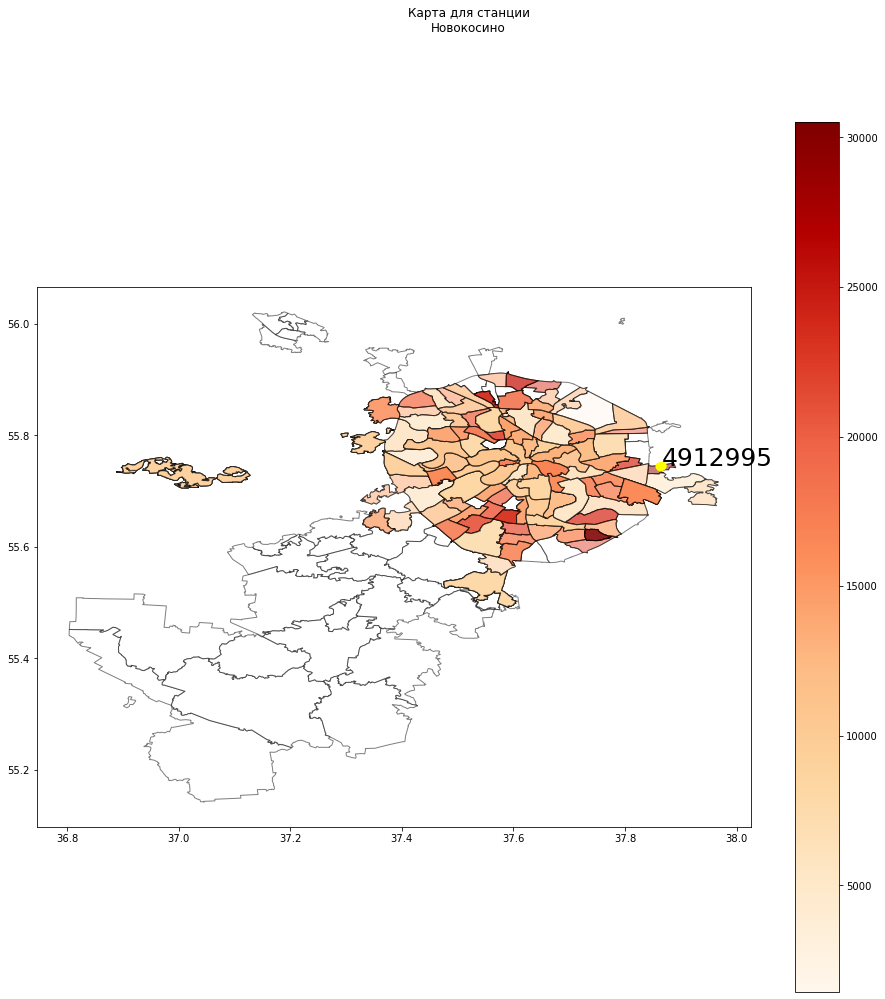

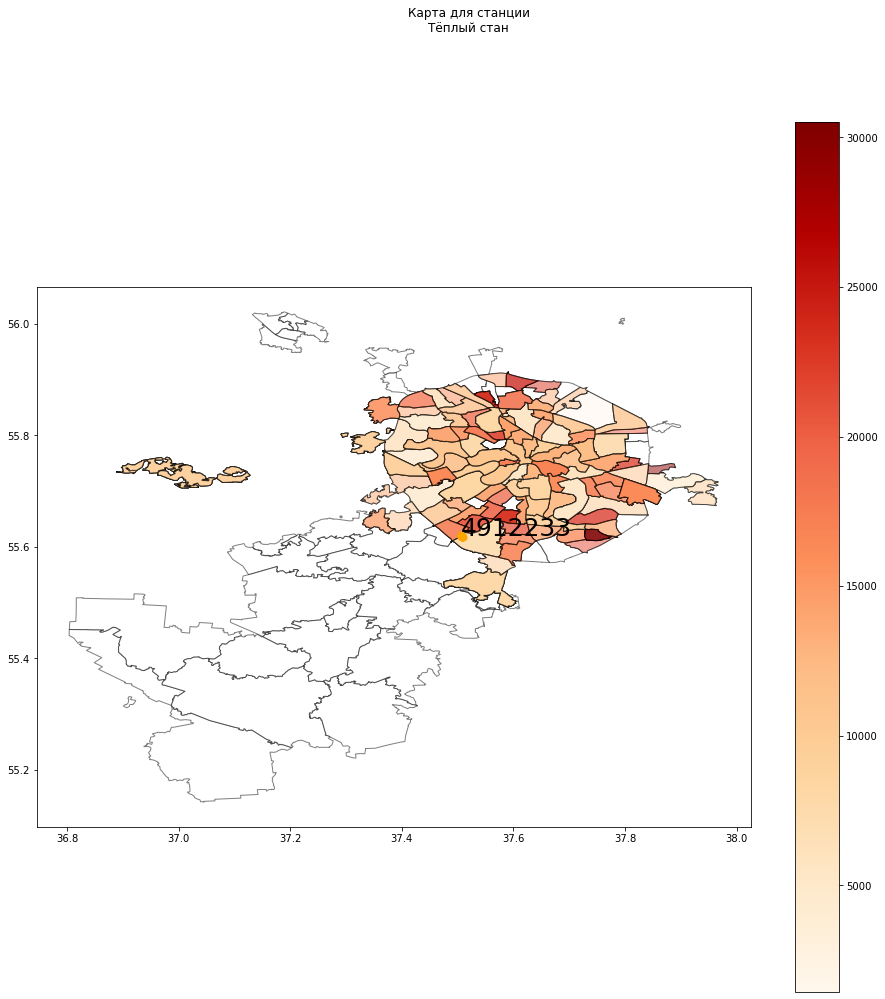

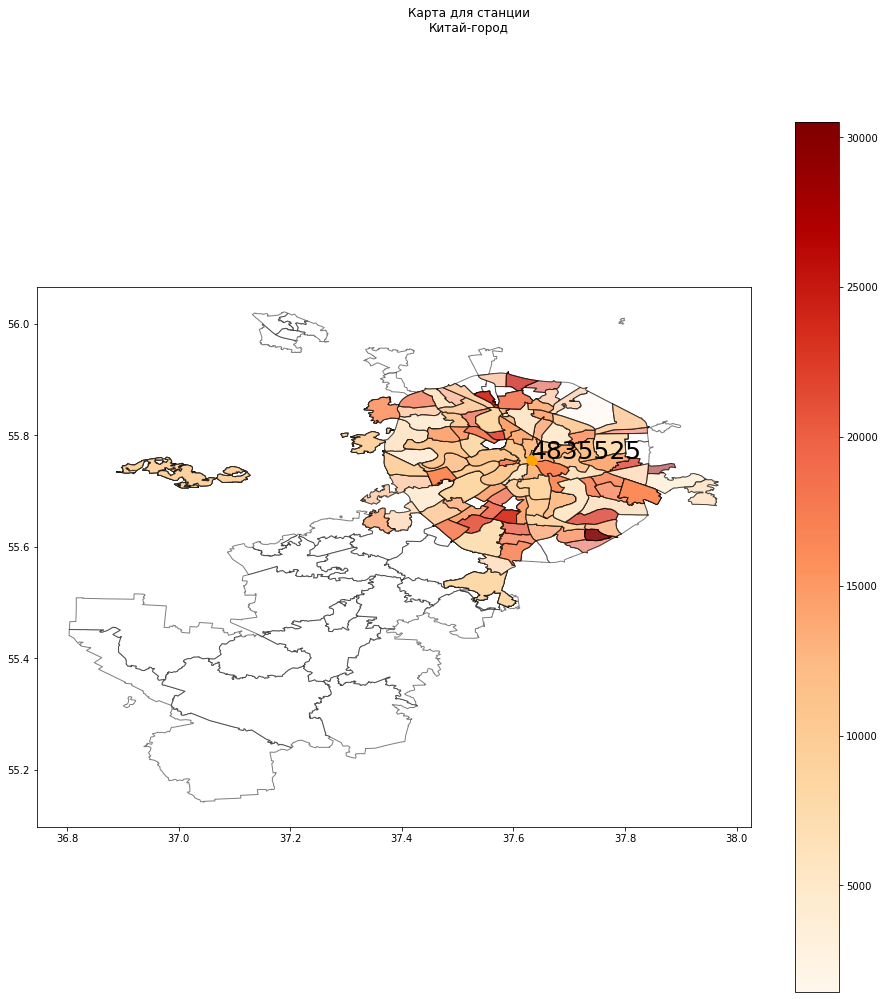

In [73]:
all_lines = metro_pas[['NameOfStation', 'IncomingPassengers','OutgoingPassengers','Line']][metro_pas['Year and quarter'] == 'I квартал2023']
sorted_inc = all_lines.sort_values(by = 'IncomingPassengers',ascending = False,ignore_index = True)
for i in range(10):
    map_1(sorted_inc['NameOfStation'].iloc[i],sorted_inc['Line'].iloc[i])

Ожидаемо, побеждают либо станции, где расположены вокзалы (как Комсомольская), либо станции, где большой пассажиропоток людей, приезжающих из Подмосковья (ВДНХ, Щелковская, Теплый Стан), либо Выхино :)

#### Спасибо за внимание!